In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Step 1a - Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and retrieve date and prcp values

# find last date in the dataset
from datetime import datetime
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0] 
last_date=datetime.strptime(last_date, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
last_date_PY=last_date - dt.timedelta(days=366) 

# Perform a query to retrieve the data and precipitation scores
year_data=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >last_date_PY).\
    order_by(Measurement.date).all()

year_data


[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF=pd.DataFrame(year_data, columns=['date','precipitation'])
#prcpDF.set_index(prcpDF['date'],inplace=True) # do we need this?
prcpDF.set_index('date',inplace=True)

# Sort the dataframe by date
prcpDF=prcpDF.sort_index()
prcpDF.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


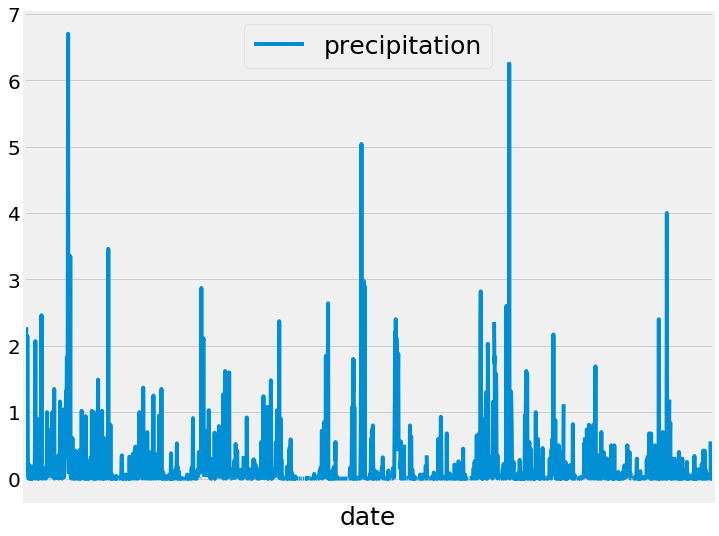

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpDF.plot(rot=90, label='precipitation', fontsize=20, figsize=(11,9)) 
legend=plt.legend(loc=9, fontsize=25) #resize and set legend to top centter
# (comment out row 5 to bring in xticks and vertical grid)
plt.xticks([],[]) # to remove xticks; also removed a vertical grid 
plt.xlabel('date', fontsize=25)

# Print image and show the plot
plt.savefig("HW_Images/Precipitation.png", bbox_inches="tight") #bbox_inches="tight"
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Step 1b - Station Analysis

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Which station has the highest number of observations?
# retrieve the top active station
most_active_station = stations[0][0]
most_active_station

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp=[func.min(Measurement.tobs),
     func.max(Measurement.tobs),
     func.avg(Measurement.tobs)]
active_station=session.query(*temp).\
    filter(Measurement.station==most_active_station).all()
active_station

[(54.0, 85.0, 71.66378066378067)]

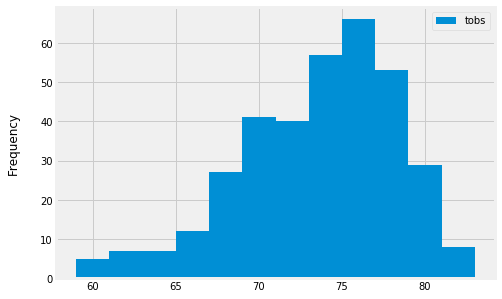

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
annual_data=session.query(Measurement.date, Measurement.tobs).\
    filter (Measurement.date>last_date_PY).\
    filter (Measurement.station==most_active_station).all()

#write qury results into DataFrame
stationDF=pd.DataFrame(annual_data, columns=['date','tobs'])
#create a histogram
stationDF.hist(column='tobs', bins=12, label='tobs', figsize=(7,5))
# Remove title
plt.title("")
# Set y-axis label
plt.ylabel("Frequency", labelpad=20, size=12)
# Set legend
plt.legend()
plt.savefig("HW_Images/tobs.png", bbox_inches="tight")
plt.show()

# Step 2 - Climate App

In [19]:
# see Climet_App.ipynb file for queries used in requested API's
# see see SQLhw_Climate_App.py for FLASK code


# Optional Challenge Assignment

## Temperature Analysis I - did not get to.  FLASK took a lot of time

## Temperature Analysis II

In [20]:
# Use function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-22', '2017-06-29'))

[(71.0, 77.34693877551021, 82.0)]


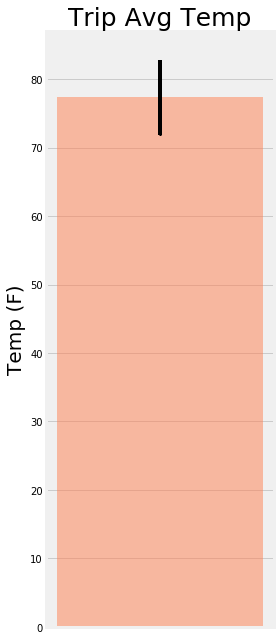

In [21]:
# write query results into a dataframe
vacationDF=pd.DataFrame(calc_temps('2017-06-22', '2017-06-29'), columns=['TMIN','TAVG', 'TMAX'])

x=["vacation"]
y=vacationDF['TAVG']
min_max=np.array([vacationDF.TMAX, vacationDF.TMIN])
error=np.std(min_max)

fig, ax = plt.subplots(figsize=(4,9))
ax.bar(x, y, yerr=error, align='center', color='coral', alpha=0.5, capsize=1)

ax.set_xticks([],[]) # to remove xticks
#ax.figure(figsize=(1,10))
#fig=plt.figure(figsize=(2,10))
ax.set_title('Trip Avg Temp', fontsize=25)
ax.set_ylabel('Temp (F)', fontsize=20)

#Save the figure and show
fig.tight_layout()
plt.savefig("HW_Images/vac_temp.png")
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Use function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def rainfall_stations(start_date, end_date):
    """show noted rainfall data per weather station.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        noted items on line 2 per weather station for your trip dates using the 
        previous year's matching dates in descending order.
    """
    # JOIN two tables and select requested columns
    sel = [Measurement.station, Station.name, Station.latitude, 
           Station.longitude, Station.elevation, Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()


print(rainfall_stations('2017-06-22', '2017-06-29'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.28), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


## Daily Rainfall Average - did not get to.  FLASK took a lot of time

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
